In [1]:
import numpy as np
import sympy as sym
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Definitions for pressure/mass/etc function evaluations

# Define Hermite basis functions

def H3 (n, t):
    
    if n == 0:
        return 1 - 3*t**2 + 2*t**3
    elif n == 1:
        return t - 2*t**2 + t**3
    elif n == 2:
        return -t**2 + t**3
    elif n == 3:
        return 3*t**2 - 2*t**3
    else:
        raise Exception('Invalid n')
        
        
# Define the interval mapping function

def tau_func (x_ab):
    
    x_f = sym.Symbol('x')
    
    return (x_f - x_ab[0])/(x_ab[1] - x_ab[0])


# Define the pressure interpolating function

def P_func (x_ab, P_ab, dP_ab):
    
    x_f = sym.Symbol('x')
    t_f = tau_func(x_ab)
    h = x_ab[1] - x_ab[0]
    
    return P_ab[0]*H3(0, t_f) + h*dP_ab[0]*H3(1, t_f) + h*dP_ab[1]*H3(2, t_f) + P_ab[1]*H3(3, t_f)


# Define the pressure gradient interpolating function

def dP_func (x_ab, P_ab, dP_ab):
    
    x_f = sym.Symbol('x')
    P_f = P_func(x_ab, P_ab, dP_ab)

    return sym.diff(P_f, x_f)


# Define the mass-squared interpolating function

def m2_func (x_ab, P_ab, dP_ab, m2_a):
    
    x_f = sym.Symbol('x')
    dP_f = dP_func(x_ab, P_ab, dP_ab)
    
    dm2_f = -8*np.pi*sym.integrate(x_f**4*dP_f, x_f)
        
    return m2_a + dm2_f - dm2_f.evalf(subs={x_f:x_ab[0]})


# Define the mass interpolating function

def m_func (x_ab, P_ab, dP_ab, m2_a):
    
    m2_f = m2_func(x_ab, P_ab, dP_ab, m2_a)
        
    return sym.sqrt(m2_f)
    

# Define the density interpolating function

def rho_func (x_ab, P_ab, dP_ab, m2_a):
    
    x_f = sym.Symbol('x')
    dP_f = dP_func(x_ab, P_ab, dP_ab)
    m_f = m_func(x_ab, P_ab, dP_ab, m2_a)
    
    return -dP_f*x_f**2/m_f #sym.diff(m_)/(4*np.pi*x_**2)


In [13]:
### Definitions for optimization

# Define i'th inequality constraint for pressure gradient

def ineq_dP (y, i):
    
    # Extract pressures and pressure gradients
    
    n = len(y)//2
    
    P = y[:n]
    dP = y[n:]
    
    # Set up constraint
    
    C = -dP[i]
    
    # Return it
    
    return C


# Define Jacobian of ineq_dP

def jac_ineq_dP (y, i):
    
    # Extract pressures and pressure gradients
    
    n = len(y)//2
    
    P = y[:n]
    dP = y[n:]
    
    # Set up constraint Jacobian
    
    dC = np.zeros(2*n)
    dC[n+i] = -1.
    
    # Return it
    
    return dC


# Define i'th inequality constraint for pressure change

def ineq_delP (y, i, left, x_AB):
    
    # Extract pressures and pressure gradients
    
    n = len(y)//2
    
    P = y[:n]
    dP = y[n:]
    
    # Set up positions of points
    
    x = np.linspace(x_AB[0], x_AB[1], n)
    
    # Calculate mean pressure slope
    
    if left:
        if i > 0:
            delP = (P[i] - P[i-1])/(x[i] - x[i-1])
        else:
            raise Exception('Mean pressure slope undefined for left=True/i=0')
    else:    
        if i < n-1:
            delP = (P[i+1] - P[i])/(x[i+1] - x[i])
        else:
            raise Exception('Mean pressure slope undefined for left=False/i=n-1')
            
    # Set up the constraint
    
    C = dP[i] - 3*delP
        
    # Return it
    
    return C

    
# Define Jacobian of ineq_delP

def jac_ineq_delP (y, i, left, x_AB):
    
    # Extract pressures and pressure gradients
    
    n = len(y)//2
    
    P = y[:n]
    dP = y[n:]
    
    # Set up positions of points
    
    x = np.linspace(x_AB[0], x_AB[1], n)
    
    # Set up constraint Jacobian
    
    dC = np.zeros(2*n)
    
    if left:
        if i > 0:
            dC[i-1] = 3/(x[i] - x[i-1])
            dC[i] = -3/(x[i] - x[i-1])
        else:
            raise Exception('Mean pressure slope undefined for left=True/i=0')
    else:    
        if i < n-1:
            dC[i] = 3/(x[i+1] - x[i])
            dC[i+1] = -3/(x[i+1] - x[i])
        else:
            raise Exception('Mean pressure slope undefined for left=False/i=n-1')
        
    dC[n+i] = 1.
    
    # Return it
    
    return dC


# Define equality constraints for pressure

def eq_P (y, i, P_i):
    
    # Extract pressures and pressure gradients
    
    n = len(y)//2
    
    P = y[:n]
    dP = y[n:]
     
    # Set up the equality constraint
    
    C = P[i] - P_i
    
    # Return it
    
    return C


# Define Jacobian of eq_P

def jac_eq_P (y, i, P_i):
    
    # Extract pressures and pressure gradients
    
    n = len(y)//2
    
    P = y[:n]
    dP = y[n:]
     
    # Set up the constraint Jacobian
    
    dC = np.zeros(2*n)
    
    dC[i] = 1.
    
    # Return it
    
    return dC


# Define equality constraints for pressure gradient

def eq_dP (y, i, dP_i):
    
    # Extract pressures and pressure gradients
    
    n = len(y)//2
    
    P = y[:n]
    dP = y[n:]
     
    # Set up the equality constraint
    
    C = dP[i] - dP_i
    
    # Return it
    
    return C


# Define Jacobian of eq_dP

def jac_eq_dP (y, i, dP_i):
    
    # Extract pressures and pressure gradients
    
    n = len(y)//2
    
    P = y[:n]
    dP = y[n:]
     
    # Set up the constraint Jacobian
    
    dC = np.zeros(2*n)
    
    dC[n+i] = 1.
    
    # Return it
    
    return dC


# Define the equality constraint for mass conservation

def eq_mass (y, x_AB, m2_AB):
    
    # Extract pressures and pressure gradients
    
    n = len(y)//2
    
    P = y[:n]
    dP = y[n:]
     
    # Set up positions of points
    
    x = np.linspace(x_AB[0], x_AB[1], n)
    
    # Calculate the mass at the end of the interval
    
    x_f = sym.Symbol('x')

    m2_b = m_AB[0]**2
    
    for i in range(1, n):
        
        x_a = x[i-1]
        P_a = P[i-1]
        dP_a = dP[i-1]
            
        x_b = x[i]
        P_b = P[i]
        dP_b = dP[i]
        
        m2_a = m2_b
        
        m2_f = m2_func([x_a,x_b], [P_a,P_b], [dP_a,dP_b], m2_a)

        m2_b = m2_f.evalf(subs={x_f:x_b})
        
    # Set up the equality constraint
    
    C = m2_b - m_AB[1]**2
    
    # Return it
    
    return C


# Define second derivative variance function (to be minimized)

def var_d2P (y, args):
    
    # Extract pressures and pressure gradients
    
    n = len(y)//2
    
    P = y[:n]
    dP = y[n:]
    
    # Unpack extra args
    
    x_AB = args[0]
    
    # Set up positions of points
    
    x = np.linspace(x_AB[0], x_AB[1], n)
    
    # Evaluate mean second derivative
    
    mean_d2P = (dP[-1] - dP[0])/(x_AB[1] - x_AB[0])
    
    # Evaluate second derivative variance
    
    var_d2P = 0.
    
    for i in range(1,n):
        
        # Evaluate d2P at the start and end of the subinterval
        
        x_a = x[i-1]
        P_a = P[i-1]
        dP_a = dP[i-1]
            
        x_b = x[i]
        P_b = P[i]
        dP_b = dP[i]
            
        d2P_a =  6*(P_b - P_a)/(x_b - x_a)**2 - 2*(dP_b + 2*dP_a)/(x_b - x_a)
        d2P_b = -6*(P_b - P_a)/(x_b - x_a)**2 + 2*(2*dP_b + dP_a)/(x_b - x_a)
    
        # Add in the integrated contribution to the variance
        
        var_d2P += (d2P_a**2 + d2P_a*d2P_b + d2P_b**2)*(x_b - x_a)/3
            
    var_d2P /= (x_AB[1] - x_AB[0])
        
    # Return it
    
    return var_d2P


# Interval optimization routine for a fixed number (n) of interior points

def opt_inter_fix (n, x_AB, P_AB, dP_AB, m_AB):
    
    # Check that n is positive
    
    if n < 3:
        raise Exception('n is less than 3')

    # Check that the boundary pressures are monotonic
    
    if P_AB[1] > P_AB[0]:
        raise Exception('P_b is greater than P_a')

    # Check that the boundary slopes are monotonic
    
    if dP_AB[0] > 0:
        raise Exception('dP_a is greater than 0')
        
    if dP_AB[1] > 0:
        raise Exception('dP_b is greater than 0')
        
    # Set up positions of points
    
    x = np.linspace(x_AB[0], x_AB[1], n)
    
    # Set up initial guesses for pressure and pressure slopes
    
    P = np.linspace(P_AB[0], P_AB[1], n)

    dP = np.empty(n)
    dP[:] = (P_AB[0] - P_AB[1])/(x_AB[1] - x_AB[0])
    
    # Set up constraints list
    
    const_list = []
    
    # P at boundaries
    
    const_list += [{'type': 'eq',
                    'fun': eq_P,
                    'jac': jac_eq_P,
                    'args': [0, P_AB[0]]}]

    const_list += [{'type': 'eq',
                    'fun': eq_P,
                    'jac': jac_eq_P,
                    'args': [n-1, P_AB[1]]}]
    
    # dP at boundaries
    
    const_list += [{'type': 'eq',
                    'fun': eq_dP,
                    'jac': jac_eq_dP,
                    'args': [0, dP_AB[0]]}]

    const_list += [{'type': 'eq',
                    'fun': eq_dP,
                    'jac': jac_eq_dP,
                    'args': [n-1, dP_AB[1]]}]
    
    # dP at points is negative
    
    for i in range(n):
        const_list += [{'type': 'ineq',
                        'fun': ineq_dP,
                        'jac': jac_ineq_dP,
                        'args': [i]}]
        
    # Pressure in subintervals is monotonic
    
    for i in range(n):
        if i > 0:
            const_list += [{'type': 'ineq',
                            'fun': ineq_delP,
                            'jac': jac_ineq_delP,
                            'args': [i, True, x_AB]}]
        if i < n-1:
            const_list += [{'type': 'ineq',
                            'fun': ineq_delP,
                            'jac': jac_ineq_delP,
                            'args': [i, False, x_AB]}]
        
    # Mass is conserved
    
    const_list += [{'type': 'eq',
                    'fun': eq_mass,
                    'args': [x_AB, m_AB]}]
    
    # Set up the solution vector
    
    y = np.append(P, dP)
    
    # Perform the optimization
    
    res = opt.minimize(var_d2P, y, [x_AB, P_AB, dP_AB], method='SLSQP', constraints=const_list,
                       options={'eps': 1e-6, 'ftol': 1e-12, 'maxiter': 1000, 'disp': True})
    
    # Set up results data
    
    if res.success:
        
        # Pressure and pressure gradient
        
        P = res.x[:n]
        dP = res.x[n:]
        
        # Mass and density
        
        m2 = np.empty(n)
        rho = np.empty(n)

        x_f = sym.Symbol('x')

        m2[0] = m_AB[0]**2
        
        
        P_f = P_func( [x[0],x[1]], [P[0],P[1]], [dP[0],dP[1]], )
        coeff = sym.Poly(P_f).all_coeffs()[1]
        rho[0] = 3/(4*np.pi)*(-8*np.pi*coeff/3)**0.5
        
        for i in range(1, n):

            x_ab = [x[i-1],x[i]]
            P_ab = [P[i-1],P[i]]
            dP_ab = [dP[i-1],dP[i]]
            
            m2_a = m2[i-1]

            m2_f = m2_func(x_ab, P_ab, dP_ab, m2_a)
            rho_f = rho_func(x_ab, P_ab, dP_ab, m2_a)
            
            m2[i] = m2_f.evalf(subs={x_f:x_ab[1]})
            rho[i] = rho_f.evalf(subs={x_f:x_ab[1]})
            
    else:
        
        x = None
        P = None
        dP = None
        m2 = None
        rho = None
        
    #print('m_a = ', rho[0]*(4*np.pi/3)*(x[-1]**3 - x[0]**3))
    #print('m_int = ',np.sqrt(m2[1]) )
    #print('m_b = ', rho[-1]*(4*np.pi/3)*(x[-1]**3 - x[0]**3))
    
    #print('rho_a = ', rho[0])
    #print('rho_int = ', rho[1])
    #print('rho_b = ', rho[-1])
        
    return x, P, dP, m2, rho, res.fun, n


# Plot data

def plot_data (x, P, dP, m2, rho, n_over=25):
    
    # Check on x, P and dP
    
    if x is None:
        raise Exception('x is None')
    if P is None:
        raise Exception('P is None')
    if dP is None:
        raise Exception('dP is None')
    if m2 is None:
        raise Exception('m2 is None')
    if rho is None:
        raise Exception('rho is None')
        
    # Set up interpolation functions
    
    n = len(P)
    
    x_f = sym.Symbol('x')
    
    P_f = []
    dP_f = []
    m2_f = []
    rho_f = []
    
    for j in range(1, n):
        
        x_ab = [x[j-1],x[j]]
        P_ab = [P[j-1],P[j]]
        dP_ab = [dP[j-1],dP[j]]
        m2_a = m2[j-1]
        
        P_f += [sym.lambdify(x_f, P_func(x_ab, P_ab, dP_ab), 'numpy')]
        dP_f += [sym.lambdify(x_f, dP_func(x_ab, P_ab, dP_ab), 'numpy')]
        m2_f += [sym.lambdify(x_f, m2_func(x_ab, P_ab, dP_ab, m2_a), 'numpy')]
        rho_f += [sym.lambdify(x_f, rho_func(x_ab, P_ab, dP_ab, m2_a), 'numpy')]
    
    # Set up the interpolation x
    
    xi = np.linspace(x[0], x[-1], (n-1)*n_over+1)
    
    ni = len(xi)
    
    # Calculate the interpolated pressure, pressure gradient and mass
    
    Pi = np.empty(ni)
    dPi = np.empty(ni)
    m2i = np.empty(ni)
    rhoi = np.empty(ni)
    
    for i in range(ni):

        j = np.where(xi[i] >= x[:n-1])[0][-1]

        Pi[i] = P_f[j](xi[i])
        dPi[i] = dP_f[j](xi[i])
        m2i[i] = m2_f[j](xi[i])

        if xi[i] > 0:
            rhoi[i] = rho_f[j](xi[i])
        if xi[i] == 0:
            Pi_f = P_func( [x[j],x[j+1]], [P[j],P[j+1]], [dP[j],dP[j+1]] )
            coeff = sym.Poly(Pi_f).all_coeffs()[1]
            rhoi[i] = 3/(4*np.pi)*(-8*np.pi*coeff/3)**0.5
            
            
    # Do the plot

    fig, ax = plt.subplots(2,2, figsize=[10,6])

    ax[0][0].plot(xi, Pi)
    ax[0][0].scatter(x, P)
    ax[0][0].scatter(x[1:-1], P[1:-1], color='orange')
    ax[0][0].set_xlabel('x')
    ax[0][0].set_ylabel('P')
    
    ax[1][0].plot(xi, dPi)
    ax[1][0].scatter(x, dP)
    ax[1][0].scatter(x[1:-1], dP[1:-1], color='orange')
    ax[1][0].set_xlabel('x')
    ax[1][0].set_ylabel('dP/dx')
    
    ax[0][1].plot(xi, np.sqrt(m2i))
    ax[0][1].scatter(x, np.sqrt(m2), color='orange')
    ax[0][1].set_xlabel('x')
    ax[0][1].set_ylabel(r'$m$')
    
    ax[1][1].plot(xi, rhoi)
    ax[1][1].scatter(x, rho, color='orange')
    ax[1][1].set_xlabel('x')
    ax[1][1].set_ylabel(r'$\rho$')
    
    fig.tight_layout()
    fig.savefig('pch.png')
    
    return 
    

In [14]:
# Interval optimization routine for a dynamic number of interior points

def opt_inter_dyn (n_max, x_AB, P_AB, dP_AB, m2_AB):
    
    # Loop over n until we find a solution, or an upper limit is reached
    
    n_upper = n_max
    fmin = [0,0]
    
    for n in range(1+2, n_upper+1):
        
        x, P, dP, m2, rho, fmin[0], _ = opt_inter_fix(n, x_AB, P_AB, dP_AB, m2_AB)
        
        # Check for completion
        
        if x is not None:
            
            if n==3:
                
                # First solution, no other solution to check against. Continue optimizing.
                
                fmin[1] = fmin[0]
                
            elif n==n_upper:
                
                # Last solution, no optimum found. Return this best solution.
                
                print('Max n was best n. Re-attempt higher n.')
                return x, P, dP, m2, rho
                
            else:
                
                if fmin[0] < fmin[1]:
                    
                    # If current solution less than previous solution, good. Continue optimizing.
                    
                    fmin[1] = fmin[0]
                
                else:
                    
                    # If current solution greater than previous, the previous was optimal.
                    
                    print("min func value = ",fmin[1])
                    print("num points = ", n-1)
                    
                    x, P, dP, m2, rho, _, _ = opt_inter_fix(n-1, x_AB, P_AB, dP_AB, m2_AB)
    
                    return x, P, dP, m2, rho
            
    # Return a null result
    
    return None, None, None, None, None

# This counts upward from low number of points to high number. Let's try reversing this...

In [15]:
# Interval optimization routine for a dynamic number of interior points

def opt_inter_dyn_min (n_max, x_AB, P_AB, dP_AB, m2_AB):
    
    # Loop over n as long as we find a solution, until a lower limit is reached
    
    n_min = n_max+1
    
    nrange = range(1+2, n_max+1)[::-1]
    
    for n in nrange:
        
        x, P, dP, m2, rho, f_min, _ = opt_inter_fix(n, x_AB, P_AB, dP_AB, m2_AB)
        
        # Check for completion
        
        if x is not None:
            
            # If n > 3, set n_min = n+1 and continue
            
            if n > nrange[-1]:
                
                n_min = n
                
                print(f'n={n}. Solution found.')
                
                continue
            
            # If n loops down to 3, n_min = 2+1.
                
            else:
                
                n_min = n
                
                print(f'n={n_min}. Solution found at n_min.')
                
                return x, P, dP, m2, rho, f_min, n_min
                
        # Else if x *is* none...
        
        else:
            
            # If n_min has been found
            
            if n_min < n_max+1:
                
                print(f'n_min={n_min}. Returning solution.')
                
                x, P, dP, m2, rho, f_min, _ = opt_inter_fix(n_min, x_AB, P_AB, dP_AB, m2_AB)
                
                return x, P, dP, m2, rho, f_min, n_min
                
            # If n_min has not been found
                
            else:
                
                print('No min found.')
                
                #break
            
            # If n is still looping
            
            if n > nrange[-1]:
                
                print(f'n={n}. x is none. Continue searching.')
                
            # If n has stopped and still no solution was found.
                
            else:
                
                print(f'n={n}. x is none. No solutions found.')
                
                break
        
    # Return a null result
    
    return None, None, None, None, None, None, None

eta=0

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 27.957649649225772
            Iterations: 25
            Function evaluations: 483
            Gradient evaluations: 25
n=8. Solution found.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 27.989147156486275
            Iterations: 22
            Function evaluations: 370
            Gradient evaluations: 22
n=7. Solution found.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 28.137543968086376
            Iterations: 19
            Function evaluations: 273
            Gradient evaluations: 18
n=6. Solution found.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 29.220083808931232
            Iterations: 13
            Function evaluations: 167
            Gradient evaluations: 13
n=5. Solution found.
Positive directional derivative for linesearch    (Exit mode 8)
    

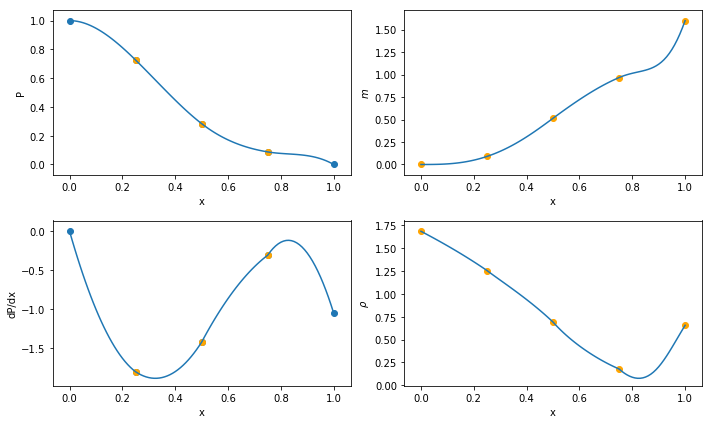

In [16]:
# Set up input state

x_AB = [0,1]
P_AB = [1,0]
dP_AB = [0,-1.05] 
m_AB = [0,1.6]

n_max = 8
# Perform the optimization

x1, P1, dP1, m21, rho1, f_min, n_min = opt_inter_dyn_min(n_max, x_AB, P_AB, dP_AB, m_AB)

plot_data(x1, P1, dP1, m21, rho1)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 29.807234952924887
            Iterations: 69
            Function evaluations: 1344
            Gradient evaluations: 65
No min found.
n=6. x is none. Continue searching.
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 31.880939663461387
            Iterations: 33
            Function evaluations: 452
            Gradient evaluations: 29
No min found.
n=5. x is none. Continue searching.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 33.164348309888
            Iterations: 12
            Function evaluations: 153
            Gradient evaluations: 12
n=4. Solution found.
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 35.17776943025048
            Iterations: 3
            Function evaluations: 24
            Gradient evaluations: 3
n=3. Solution found

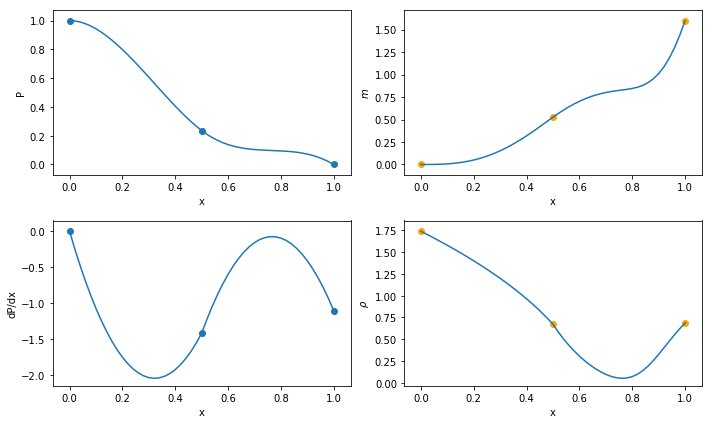

In [8]:
# Set up input state

x_AB = [0,1]
P_AB = [1,0]
dP_AB = [0,-1.1] 
m_AB = [0,1.6]

n_max = 6
# Perform the optimization

x1, P1, dP1, m21, rho1, fmin, n_min = opt_inter_dyn_min(n_max, x_AB, P_AB, dP_AB, m_AB)

plot_data(x1, P1, dP1, m21, rho1)

Why does this pressure gradient + mass combo not return solutions for n>4? I thought that, if n=3, then n->infinity. Why is this not the case? 

Is it that, once n=3 is the best fit, the error from n>3 begins to compound because it's all at machine precision? Basically, p(n,x) reaches a maximum closeness to f(x) at a particular n, bounded by polynomial accuracy from one side, and by machine precision noise from the other side.

eta=1

to do: 
    1. write polytrope solver
    2. clean interpolation code, have test n until finds solution

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 33.01589930080695
            Iterations: 3
            Function evaluations: 24
            Gradient evaluations: 3
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 29.136602036785156
            Iterations: 12
            Function evaluations: 83
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 29.220083808931232
            Iterations: 13
            Function evaluations: 167
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 28.137543968086376
            Iterations: 19
            Function evaluations: 273
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 27.989147156486275
            Iterations: 22
            

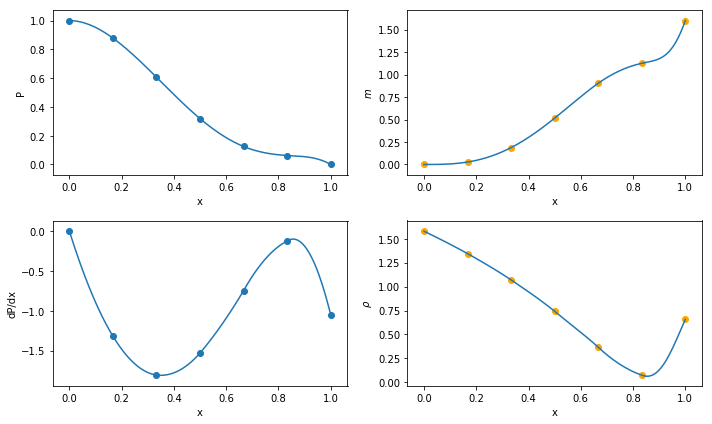

In [10]:
#x_AB = [0,1]
#P_AB = [1,0]
#dP_AB = [0,0.0] # -0.02
#m_AB = [0,2.4]

x_AB = [0,1]
P_AB = [1,0]
dP_AB = [0,-1.05] 
m_AB = [0,1.6]

n_max = 7
# Perform the optimization

x1, P1, dP1, m21, rho1 = opt_inter_dyn(n_max, x_AB, P_AB, dP_AB, m_AB)

plot_data(x1, P1, dP1, m21, rho1)

### Maximum and minimum masses for n=3

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 92.78974119162432
            Iterations: 3
            Function evaluations: 24
            Gradient evaluations: 3


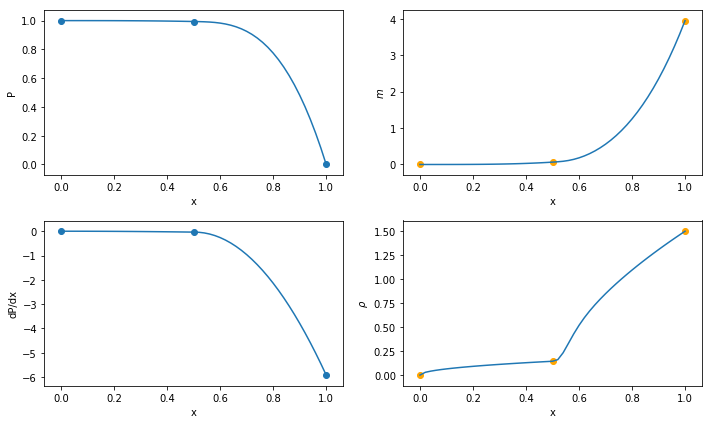

In [78]:
# Set up input state

x_AB = [0,1]
P_AB = [1,0]
dP_AB = [0,-5.92] # -0.02
m_AB = [0,3.9475] # 0.7775

n = 3 # Note that n is now the *total* number of points, including endpoints

# Perform the optimization

x1, P1, dP1, m21, rho1, _, _ = opt_inter_fix(n, x_AB, P_AB, dP_AB, m_AB)

plot_data(x1, P1, dP1, m21, rho1)


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 19.433619567307097
            Iterations: 17
            Function evaluations: 254
            Gradient evaluations: 17


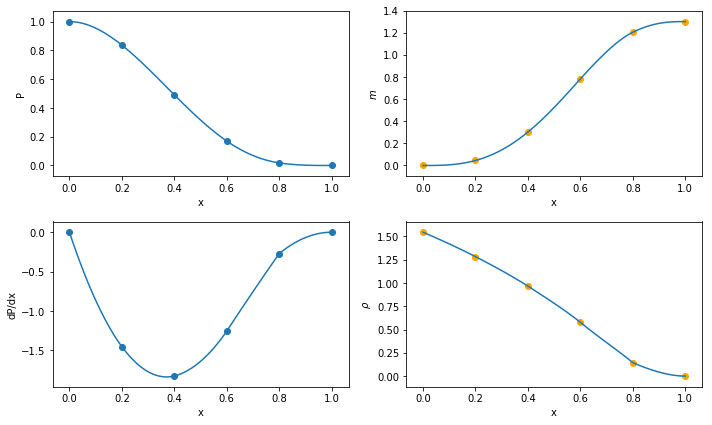

In [53]:
# Set up input state

x_AB = [0,1]
P_AB = [1,0]
dP_AB = [0,0.0] # -0.02
m_AB = [0,1.3] # 0.7775

n = 6 # Note that n is now the *total* number of points, including endpoints

# Perform the optimization

#rho_func(x_AB, P_AB, dP_AB, m_AB[0]**2)

x1, P1, dP1, m21, rho1, _,_ = opt_inter_fix(n, x_AB, P_AB, dP_AB, m_AB)

plot_data(x1, P1, dP1, m21, rho1)

( 2.25 - 0.9 )/ ( 2.6101 -0.7775 )

### Read in .mesa format model

I'm using a $5 M_\odot$ model at half the Sun's age ($x = 0.355$)

In [81]:
from astropy.io import ascii

In [82]:
model = ascii.read("test-model.mesa", data_start=1)
header = ascii.read("test-model.mesa", data_end=1)

In [83]:
N_star = header['col1']    # number of grid points
M_star = header['col2']    # /[g] , Msol = 1.98847542e33
R_star = header['col3']    # /[cm] 
P_cntr = model['col5'][0]  # /[dyn cm^-2]
dP_cntr = 0
rho_avg = M_star/R_star**3 # /[g cm^-3]

In [84]:
P_cntr

2.3758304250700752e+17

In [85]:
model['col2'][-1]

71445678605.061646

In [86]:
x_mod = model['col2'] #* (scale/R_star) 
P_mod = model['col5'] #* (scale/P_cntr) 

m_mod = model['col3'] #* (1/M_star) * scale**2 
rho_mod = model['col7'] #/ rho_avg

dP_mod = - (m_mod*rho_mod/x_mod**2) 
dP_mod[0] = 0

#rmid = ( model['col2'][:-1] + np.diff(model['col2']) )

/Users/TARS/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [87]:
dP_mod[:2]

0.0
-6.32337876701e+12


In [88]:
P_cntr

2.3758304250700752e+17

In [89]:
P_mod[:2]/P_cntr # - P_mod[:2][-1]

1.0
0.999947702161


In [90]:
x_mod[:2]

0.0
61942314.973


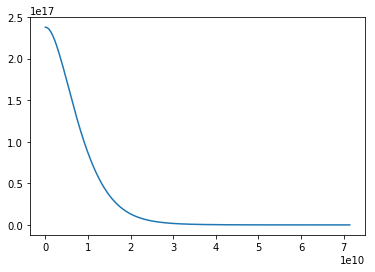

In [100]:
plt.plot(x_mod, P_mod )

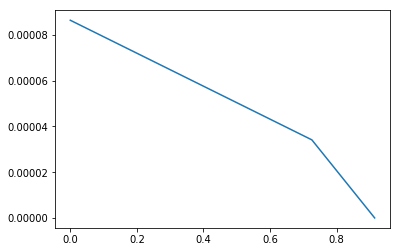

In [91]:
plt.plot(x_mod[:3]*(N_star/R_star), (P_mod[:3] - P_mod[:3][-1])/(P_cntr - P_mod[:][-1]) )

In [105]:
# Set up input state

x_AB = list( x_mod[0:2] )# *(N_star/R_star) )
P_AB = list( P_mod[0:2] ) # - P_mod[:2][-1])/(P_cntr - P_mod[:2][-1]) ) #P_mod[0:2])
dP_AB = list(dP_mod[0:2]) # /(P_cntr - P_mod[:2][-1]) 
m_AB = list(m_mod[0:2]) # * (N_star/R_star)**2/(P_cntr - P_mod[:2][-1])

n = 5 # Note that n is now the *total* number of points, including endpoints

#rho_func(x_AB, P_AB, dP_AB, m_AB[0]**2)

#print('m_a = ', rho[0]*(4*np.pi/3)*(x[-1]**3 - x[0]**3))
#print('m_int = ',np.sqrt(m2[1]) )
#print('m_b = ', rho[-1]*(4*np.pi/3)*(x[-1]**3 - x[0]**3))

# Perform the optimization

x, P, dP, m2, rho = opt_inter_dyn(n, x_AB, P_AB, dP_AB, m_AB)

#plot_data(x, P, dP, m2, rho)


Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: 0.0020134918425014883
            Iterations: 1
            Function evaluations: 8
            Gradient evaluations: 1
Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: 0.004530356645628349
            Iterations: 1
            Function evaluations: 10
            Gradient evaluations: 1
Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: 0.008053967370005955
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1


In [ ]:
x_AB

In [436]:
m_AB* (N_star/R_star)**2/(P_cntr - P_mod[:2][-1])

array([ 0.        ,  0.00298016])

In [106]:
# Interval optimization routine for a dynamic number of interior points

def opt_inter_dyn_max (n_max, x_AB, P_AB, dP_AB, m2_AB):
    
    # Loop over n until we find a solution, or an upper limit is reached
    
    n_upper = n_max
    nrange = range(1+2, n_upper+1)[::-1]
    
    fmin = [0,0]
    
    for n in nrange:
        
        x, P, dP, m2, rho, fmin[0], _ = opt_inter_fix(n, x_AB, P_AB, dP_AB, m2_AB)
        
        # Check for completion
        
        if x is not None:
            
            if n==nrange[0]:
                
                # First solution, no other solution to check against. Continue optimizing.
                
                fmin[1] = fmin[0]
                
            elif n==nrange[-1]:
                
                # Last solution, no optimum found. Return this best solution.
                
                print('Max n was best n. Re-attempt higher n.')
                return x, P, dP, m2, rho
                
            else:
                
                if fmin[0] < fmin[1]:
                    
                    # If current solution less than previous solution, good. Continue optimizing.
                    
                    fmin[1] = fmin[0]
                
                else:
                    
                    # If current solution greater than previous, the previous was optimal.
                    
                    print("min func value = ",fmin[1])
                    print("num points = ", n+1)
                    
                    x, P, dP, m2, rho, _, _ = opt_inter_fix(n+1, x_AB, P_AB, dP_AB, m2_AB)
    
                    return x, P, dP, m2, rho
        
        else:
            print('x is none.')
        
    # Return a null result
    
    return None, None, None, None, None